In [1]:
import os
import sys
from time import time

import numpy as np
import tensorflow as tf
import pandas as pd
import math

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement=True
sess = tf.Session(config=config)

In [2]:
import numpy as np
from keras.models import Sequential

Using TensorFlow backend.


In [3]:
def eval_pehe(tau_hat,tau):
    return np.sqrt(np.mean(np.square(tau-tau_hat)))

In [4]:
def onehot(t,dim):
    
    m_samples = t.shape[0]
    tt = np.zeros([m_samples,dim])
    
    for i in range(m_samples):
        tt[i,np.int(t[i])] = 1
        
    return tt

In [5]:
def load_ihdp(trial_id=0,filepath='./data/',istrain=True):
    
    if istrain:
        data_file = filepath+'ihdp_npci_1-1000.train.npz'
    else:
        data_file = filepath+'ihdp_npci_1-1000.test.npz'
        
    data = np.load(data_file)
    
    x = data['x'][:,:,trial_id]
    y = data['yf'][:,trial_id]
    t = data['t'][:,trial_id]
    ycf = data['ycf'][:,trial_id]
    mu0 = data['mu0'][:,trial_id]
    mu1 = data['mu1'][:,trial_id]
    
    return x,y,t,ycf,mu0,mu1

ihdp_ind = 0

VAL = True
NORM = True

In [6]:
X,Y,T,Ycf,Mu0,Mu1 = load_ihdp(ihdp_ind)
Tau = Mu1 - Mu0

Y = np.reshape(Y,[-1,1])
T = onehot(T,2)

X_m = np.mean(X,axis=0,keepdims=True)
X_std = np.std(X,axis=0,keepdims=True)
X = (X-X_m)/X_std

n_samples = X.shape[0]

y_std = 1.

if NORM:
    y_m = np.mean(Y)
    y_std = np.std(Y)

    Y = (Y-y_m)/y_std

    Tau = Tau/y_std

In [7]:
if VAL:

    prob_train = 0.7

    n_train_samples = int(np.ceil(prob_train*n_samples))

    shuff_idx = np.array(range(n_samples))
    # Shuffle the indices
    # np.random.shuffle(shuff_idx)

    train_idx = shuff_idx[:n_train_samples]
    val_idx = shuff_idx[n_train_samples:]

    X_val = X[val_idx]
    Y_val = Y[val_idx]
    T_val = T[val_idx]

    X = X[train_idx]
    Y = Y[train_idx]
    T = T[train_idx]

    n_samples = n_train_samples

    Tau_val = Tau[val_idx]
    Tau = Tau[train_idx]

In [8]:
def keras_generator(X,Y,T,batch_size=128):
    
    num_steps = X.shape[0] // batch_size
    
    def generator():
        
        index = 0
        n_samples = X.shape[0]
        indexes = np.arange(n_samples)
        np.random.shuffle(indexes)
        
        while True:
            
            if (index+1)*batch_size>n_samples:
                np.random.shuffle(indexes)
                index = 0
            
            ind = indexes[index*batch_size:(index+1)*batch_size]
            index += 1
            
            xx = X[ind]
            yy = Y[ind]
            tt = T[ind]
            
            yield (xx,tt),yy
            
    return generator(), num_steps

In [9]:
from baseline_models.ganite import GANITE

In [10]:
with_propensity_dropout = False
imbalance_loss_weight = 0
early_stopping_patience = 30
early_stopping_on_pehe = 30
num_layers = 3
num_units = 60
dropout = 0.
batch_size = 100

best_model_path = './best_model/'

l2_weight = 0.000
learning_rate = 1e-3

with_tensorboard = False # unclear
n_jobs = 1 #unclear
with_pehe_loss = False
use_tarnet = True
strength_of_assignment_bias = 0 # unclear

ganite_weight_alpha = .1 # unclear
ganite_weight_beta = .1 # unclear
propensity_batch_probability = 0. # unclear

match_on_covariates = False 

In [11]:
train_generator,train_steps = keras_generator(X,Y.reshape([-1,]),T[:,1],batch_size=batch_size)
val_generator,val_steps = keras_generator(X_val,Y_val.reshape([-1,]),T_val[:,1],batch_size=batch_size)

In [12]:
benchmark = None
num_randomised_neighbours = 1

In [13]:
network_params = {
            "with_propensity_dropout": with_propensity_dropout,
            "imbalance_loss_weight": imbalance_loss_weight,
            "early_stopping_patience": early_stopping_patience,
            "early_stopping_on_pehe": early_stopping_on_pehe,
            "num_layers": num_layers,
            "num_units": num_units,
            "dropout": dropout,
            "batch_size": batch_size,
            "num_treatments": 2,
            "input_dim": X.shape[1],
            "output_dim": Y.shape[1],
            "best_model_path": best_model_path,
            "l2_weight": l2_weight,
            "learning_rate": learning_rate,
            "with_tensorboard": with_tensorboard,
            "n_jobs": n_jobs,
            "benchmark": benchmark,
            "with_pehe_loss": with_pehe_loss,
            "use_tarnet": use_tarnet,
            "strength_of_assignment_bias": strength_of_assignment_bias,
            "ganite_weight_alpha": ganite_weight_alpha,
            "ganite_weight_beta": ganite_weight_beta,
            "propensity_batch_probability": propensity_batch_probability,
            "match_on_covariates": match_on_covariates,
            "num_randomised_neighbours": num_randomised_neighbours,
        }

In [ ]:
method_type = GANITE
model = method_type()
model.build(**network_params)

In [15]:
num_epochs = 50 # maximal number of epoches

model.fit_generator(train_generator=train_generator,
                                train_steps=train_steps,
                                num_epochs=num_epochs,
                                val_generator=val_generator,
                                val_steps=val_steps,
                                batch_size=batch_size)

Epoch [0000/0050] xx TRAIN: G=-0.366 D=0.576 VAL: G=-0.396 D=0.524
Epoch [0001/0050] :: TRAIN: G=-0.404 D=0.485 VAL: G=-0.392 D=0.516
Epoch [0002/0050] :: TRAIN: G=-0.329 D=0.508 VAL: G=-0.382 D=0.500
Epoch [0003/0050] :: TRAIN: G=-0.396 D=0.403 VAL: G=-0.372 D=0.477
Epoch [0004/0050] :: TRAIN: G=-0.423 D=0.347 VAL: G=-0.380 D=0.468
Epoch [0005/0050] :: TRAIN: G=-0.428 D=0.392 VAL: G=-0.392 D=0.467
Epoch [0006/0050] :: TRAIN: G=-0.328 D=0.427 VAL: G=-0.376 D=0.454
Epoch [0007/0050] :: TRAIN: G=-0.347 D=0.420 VAL: G=-0.382 D=0.447
Epoch [0008/0050] :: TRAIN: G=-0.283 D=0.431 VAL: G=-0.382 D=0.450
Epoch [0009/0050] :: TRAIN: G=-0.289 D=0.331 VAL: G=-0.377 D=0.441
Epoch [0010/0050] :: TRAIN: G=-0.299 D=0.370 VAL: G=-0.369 D=0.456
Epoch [0011/0050] :: TRAIN: G=-0.245 D=0.382 VAL: G=-0.378 D=0.458
Epoch [0012/0050] :: TRAIN: G=-0.346 D=0.322 VAL: G=-0.382 D=0.462
Epoch [0013/0050] xx TRAIN: G=-0.374 D=0.406 VAL: G=-0.409 D=0.496
Epoch [0014/0050] xx TRAIN: G=-0.436 D=0.507 VAL: G=-0.438 D=0

In [16]:
y_pred = model.predict([X,T])

tau_hat = y_pred[:,1] - y_pred[:,0]

In [17]:
pehe_mkl = eval_pehe(tau_hat, Tau)*y_std

In [18]:
print(pehe_mkl)

1.2184082726923555


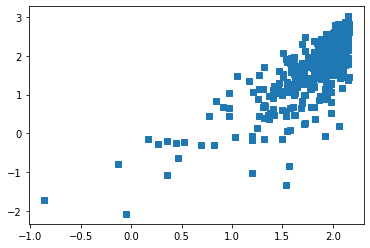

In [19]:
_ = plt.plot(Tau,tau_hat,'s')